# Préparation des données pour l'agence Santé publique France.
<br><br>
<img src="./data/img/logo-sante-publique-fr.png" style="width:500px;margin-left:auto; margin-right:auto; display: block;">
<br>

L'agence de santé souhaite rendre les données de santé publique plus accessibles. <br>
Pour ce faire, l'analyse se basera sur un jeu de données du site <a href="https://world.openfoodfacts.org/">"Open Food"</a> qui fourni un jeu de données open source.
<br><br>
Le but de cette analyse est donc de rendre compréhensible ces données pour un large public.
<br><br>
Les données traitées sur ce compte rendu ont déjà été traitées et nettoyées, cette page web à pour but d'exposer l'analyse des résultats du jeu de données, avec pour objectif la compréhension du nutriscore et la compréhension des nutriments des différents produits. 
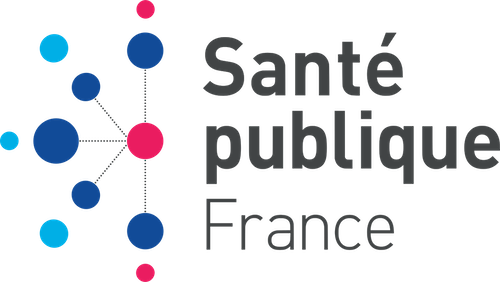

# Sommaire
<ol style="font-size: 16px;">
    <li><a href="#Analyse-statistique-du-jeu-de-données">Analyse statistique du jeu de données</a></li>
    <ol style="font-size: 14px;">
        <li><a href="#Analyse-univariée">Analyse univariée</a></li>
        <li><a href="#Analyse-en-Composante-Principale-(ACP)">Analyse en Composante Principale (ACP)</a></li>
        <li><a href="#Comparative-nutritionnel">Comparative nutritionnel</a></li>
    </ol>
    <br>
    <li><a href="#Conclusion">Conclusion</a></li>
    <br>
    <li><a href="#Recherche-de-produit">Recherche de produit</a></li>
</ol>

In [1]:
%matplotlib inline
# Native librairie
import re

# DA Librairie
import pandas as pd 
import numpy as np

# DS Librairie
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Visualisation

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from chart_studio.plotly import plot, iplot
import chart_studio.grid_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import display

from IPython.display import Image, HTML
from IPython.display import display as disp

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
def all_plan(start,n_comp=4,just_next_plan=False):
    plan=[]
    if just_next_plan:
        for i in range(start+1,n_comp,2):
            plan.append((i-1,i))
    else:
        for i in range(start,n_comp):
            for j in range(i + 1,n_comp):
                plan.append((i,j))
    return plan



def get_all_numeric_col(data):
    all_numeric_col=[]
    all_type_nume=["float64","int64"]
    for col in list(data.columns):
        dtype = str(data[col].dtypes)
        if dtype in all_type_nume:
            all_numeric_col.append(col)
    return all_numeric_col

def describe_data(data,how=[np.number,object],decimal_digit=3,numeric_value_return=False):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame pandas mais de type {type(data)}!")
    
    for v in how:
        if (str(v) != str(np.number)) & (str(v) != str(object)):
            print(f"\"how\" ne peut contenir que \"np.number\" ou \"object\", \"{str(v)}\" ne correspond pas!")
    if numeric_value_return :
        return data.describe(include=how).T
    
    if not object in how:
        if type(decimal_digit) == int:
            if decimal_digit >=0:
                digit_format ="{0:."+str(decimal_digit)+"f}"
            else:
                digit_format ="{0:."+str(0)+"f}"
        else:
            digit_format ="{0:."+str(3)+"f}"
              
        return data.describe(include=how).apply(lambda s: s.apply(digit_format.format)).T
    else:
        return data.describe(include=how).T
    
# Normalisation du graphique des 10 valeurs les plus récurrentes
def plot_qualitatives_best(data,col_name,podium_size=10):
    # vérification 
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame pandas mais de type {type(data)}!")
    
    if not col_name in data.columns:
        raise ValueError(f"La colonne {col_name} n'existe pas dans le dataset")
    
    test = data.groupby([col_name]).size().sort_values(ascending=False).head(podium_size)
    
    if len(test) == 0:
        raise ValueError(f"La colonne {col_name} ne contient aucune valeur (exclude NaN)")
    
    if len(test) < podium_size:
        podium_size = len(test)
        
        
    plt.figure(figsize=(16,11))
    
    sns.set(style="whitegrid")
    sns_palette.n_colors=podium_size
    
    ax = sns.barplot(x=test.values,y=test.index,palette=sns_palette,orient="h")

    plt.title('Nombre d\'occurences de la colonne ' + test.index.name, fontsize=16)
    plt.xlabel("Nombre d'occurrences", fontsize=14)
    plt.ylabel(test.index.name, fontsize=14)

    # affiche le nombre de valeur à droite de la barre
    for i, v in enumerate(test.values.tolist()):
        ax.text(v, i, str(v), color='black', fontweight='normal')

    plt.show()
    

# ANOVA
def anova_analysis(data,qualitative_col,quantitative_col,
                   display_na=False,
                   figsize=(20,15)):
    if not display_na:
        modalites = [m for m in data[qualitative_col].unique() if str(m)!="nan"]
    else:
        modalites = [m for m in data[qualitative_col].unique()]
    groupes = []
    for m in modalites:
        groupes.append(perfect_data[perfect_data[qualitative_col]==m][quantitative_col])
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    plt.figure(figsize=figsize)
    plt.boxplot(groupes, labels=modalites,showfliers=False, medianprops=medianprops,
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()    

# PCA
def display_circles(pcs,pca, axis_ranks,n_comp=4, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,9))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# PCA individu           
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks,sample_individu=10, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,9))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)[0][:sample_individu]
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def PCA_analysis(data, axis_ranks,n_comp=4, labels=None, label_rotation=0, lims=None,fillna_mean=False,
                 alpha=1, illustrative_var=None,sample_individu=10):
    
    data_pca = data
    if fillna_mean :
        data_pca.fillna(data.mean(),inplace=True)
    
    X = data_pca.values
    names = data_pca.index
    features = data_pca.columns
    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)

    plt.figure(figsize=(15,10))
    plt.title("Ebouli PCA")
    ebouli = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(pca.explained_variance_ratio_)),ebouli,alpha=0.9,label="inertie ratio")
    plt.plot(np.arange(len(pca.explained_variance_ratio_)),ebouli.cumsum(),c="red",ls="--",label="inertie cumulé")
    plt.legend()
    plt.show()
    
    pcs = pca.components_
    # circle correlation
    display_circles(pcs,pca,axis_ranks,n_comp,labels=labels,label_rotation=label_rotation,lims=lims)
    #data projection
    X_projected = pca.transform(X)
    display_factorial_planes(X_projected, n_comp, pca, axis_ranks,alpha=alpha ,illustrative_var=illustrative_var,sample_individu=sample_individu)

def repartition_quantitative_values_rate(data,col_quantitative,grouped_value="",normalize=True):
    if normalize:
        if grouped_value!="":
            group = data.groupby(grouped_value)
            value = group[col_quantitative].describe().loc[:,(slice(None),['mean'])].T
            new_tab = pd.DataFrame()
            for k in list(group.groups.keys()):
                all_value = value[k]
                new_tab[k]= (1 - (all_value.sum() - all_value)/all_value.sum()) * 100
            return new_tab
        else:
            value = data[col_quantitative].describe().loc[['mean']].T
            return (1 - (value.sum() - value)/value.sum()) * 100
    else:
        if grouped_value!="":
            group = data.groupby(grouped_value)
            value = group[col_quantitative].describe().loc[:,(slice(None),['mean'])].T
            new_tab = pd.DataFrame()
            for k in list(group.groups.keys()):
                all_value = value[k]
                new_tab[k]= all_value.values
            new_tab.index = col_quantitative
            return new_tab
        else:
            return data[col_quantitative].describe().loc[['mean']].T
        
def fair_distribution(data,col_qualitative,sample_size=-1,get_na_value=False,random_state=0,fillna_method=""):
    group_grade = data.groupby(col_qualitative)
    data_value=[]
    if sample_size<=0:
        sample_size=data[col_qualitative].value_counts().min()
    elif data[col_qualitative].value_counts().min() < sample_size:
        sample_size=data[col_qualitative].value_counts().min()
    if get_na_value:
        all_na = data[data[col_qualitative].astype(str)=="nan"]
        if all_na.shape[0] < sample_size:
            sample_size=all_na.shape[0]
            
    for k in group_grade[col_qualitative].groups.keys():
        data = group_grade.get_group(k)
        if fillna_method=="mean":
            data_value.append(data.fillna(data.mean()).sample(sample_size,random_state=random_state))
        else:
            data_value.append(data.sample(sample_size,random_state=random_state))
    if get_na_value:
        data_value.append(all_na.sample(sample_size,random_state=random_state))
        
    return pd.concat(data_value,axis=0)

# normalisation du graphique de carte de chaleur
def plot_heatmap(data,xlabel,ylabel,title,
                 colorbar_display=False,label_colorbar="Répartition",fmt="f",annot=True,linewidths=.1):
    plt.figure(figsize=(15,10))
    if annot:
        ax = sns.heatmap(data,cmap=sns_palette,linewidths=linewidths,annot=annot,fmt=fmt,cbar=colorbar_display)
    else:
        ax = sns.heatmap(data,cmap=sns_palette,linewidths=linewidths,annot=annot,cbar=colorbar_display)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if colorbar_display:
        ax.collections[0].colorbar.set_label(label_colorbar)
    plt.show()

In [3]:
# Palette couleur graphique utilisée
couleur = "dark:#8ab6d6"
# Création des palettes
sns_palette=sns.color_palette(couleur,n_colors=10)
mpl_palette=mpl.colors.ListedColormap([i for i in sns.color_palette(couleur,n_colors=100)])

In [4]:
data = pd.read_csv("./data/clean_data.csv",index_col="product_name",low_memory=False)
quantitative = get_all_numeric_col(data)
quantitative_exclude_energy = quantitative.copy()
quantitative_exclude_energy.remove("energy_100g")
quantitative_exclude_energy.remove("energy-kcal_100g")

In [5]:
image = data["image_url"]
data = data.drop("image_url",axis=1)

# Analyse statistique du jeu de données

Pour mieux comprendre le nettoyage du jeu de données et la création du jeu de données nettoyé rendez-vous sur le notebook (convertible "Voilà") P03_01_notebook.ipynb qui détail le nettoyage du jeu de données.

## Analyse univariée

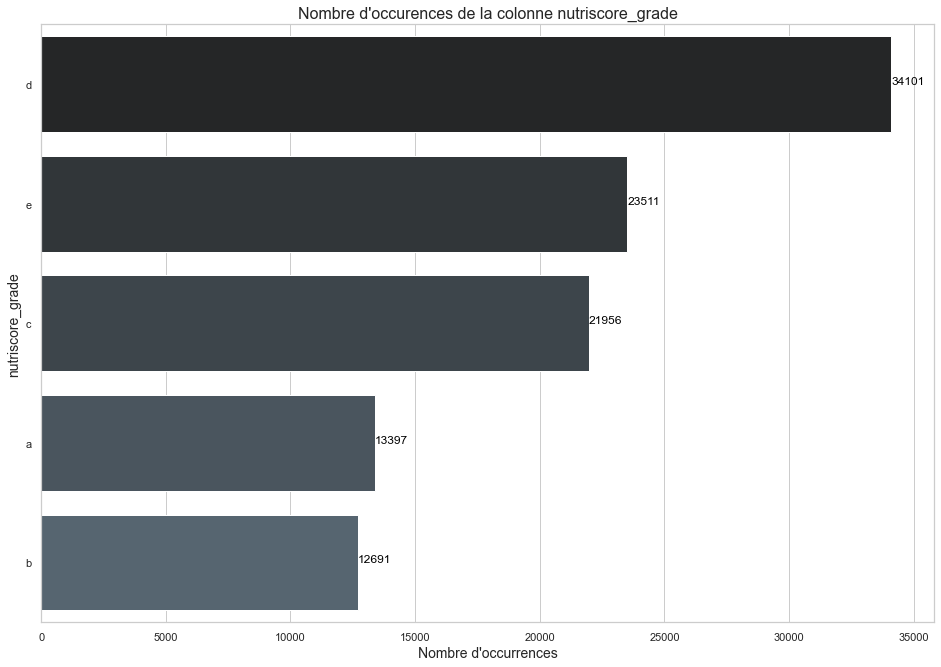

In [6]:
plot_qualitatives_best(data,"nutriscore_grade")

Nutriscore_grade relation pour chaque valeurs: 


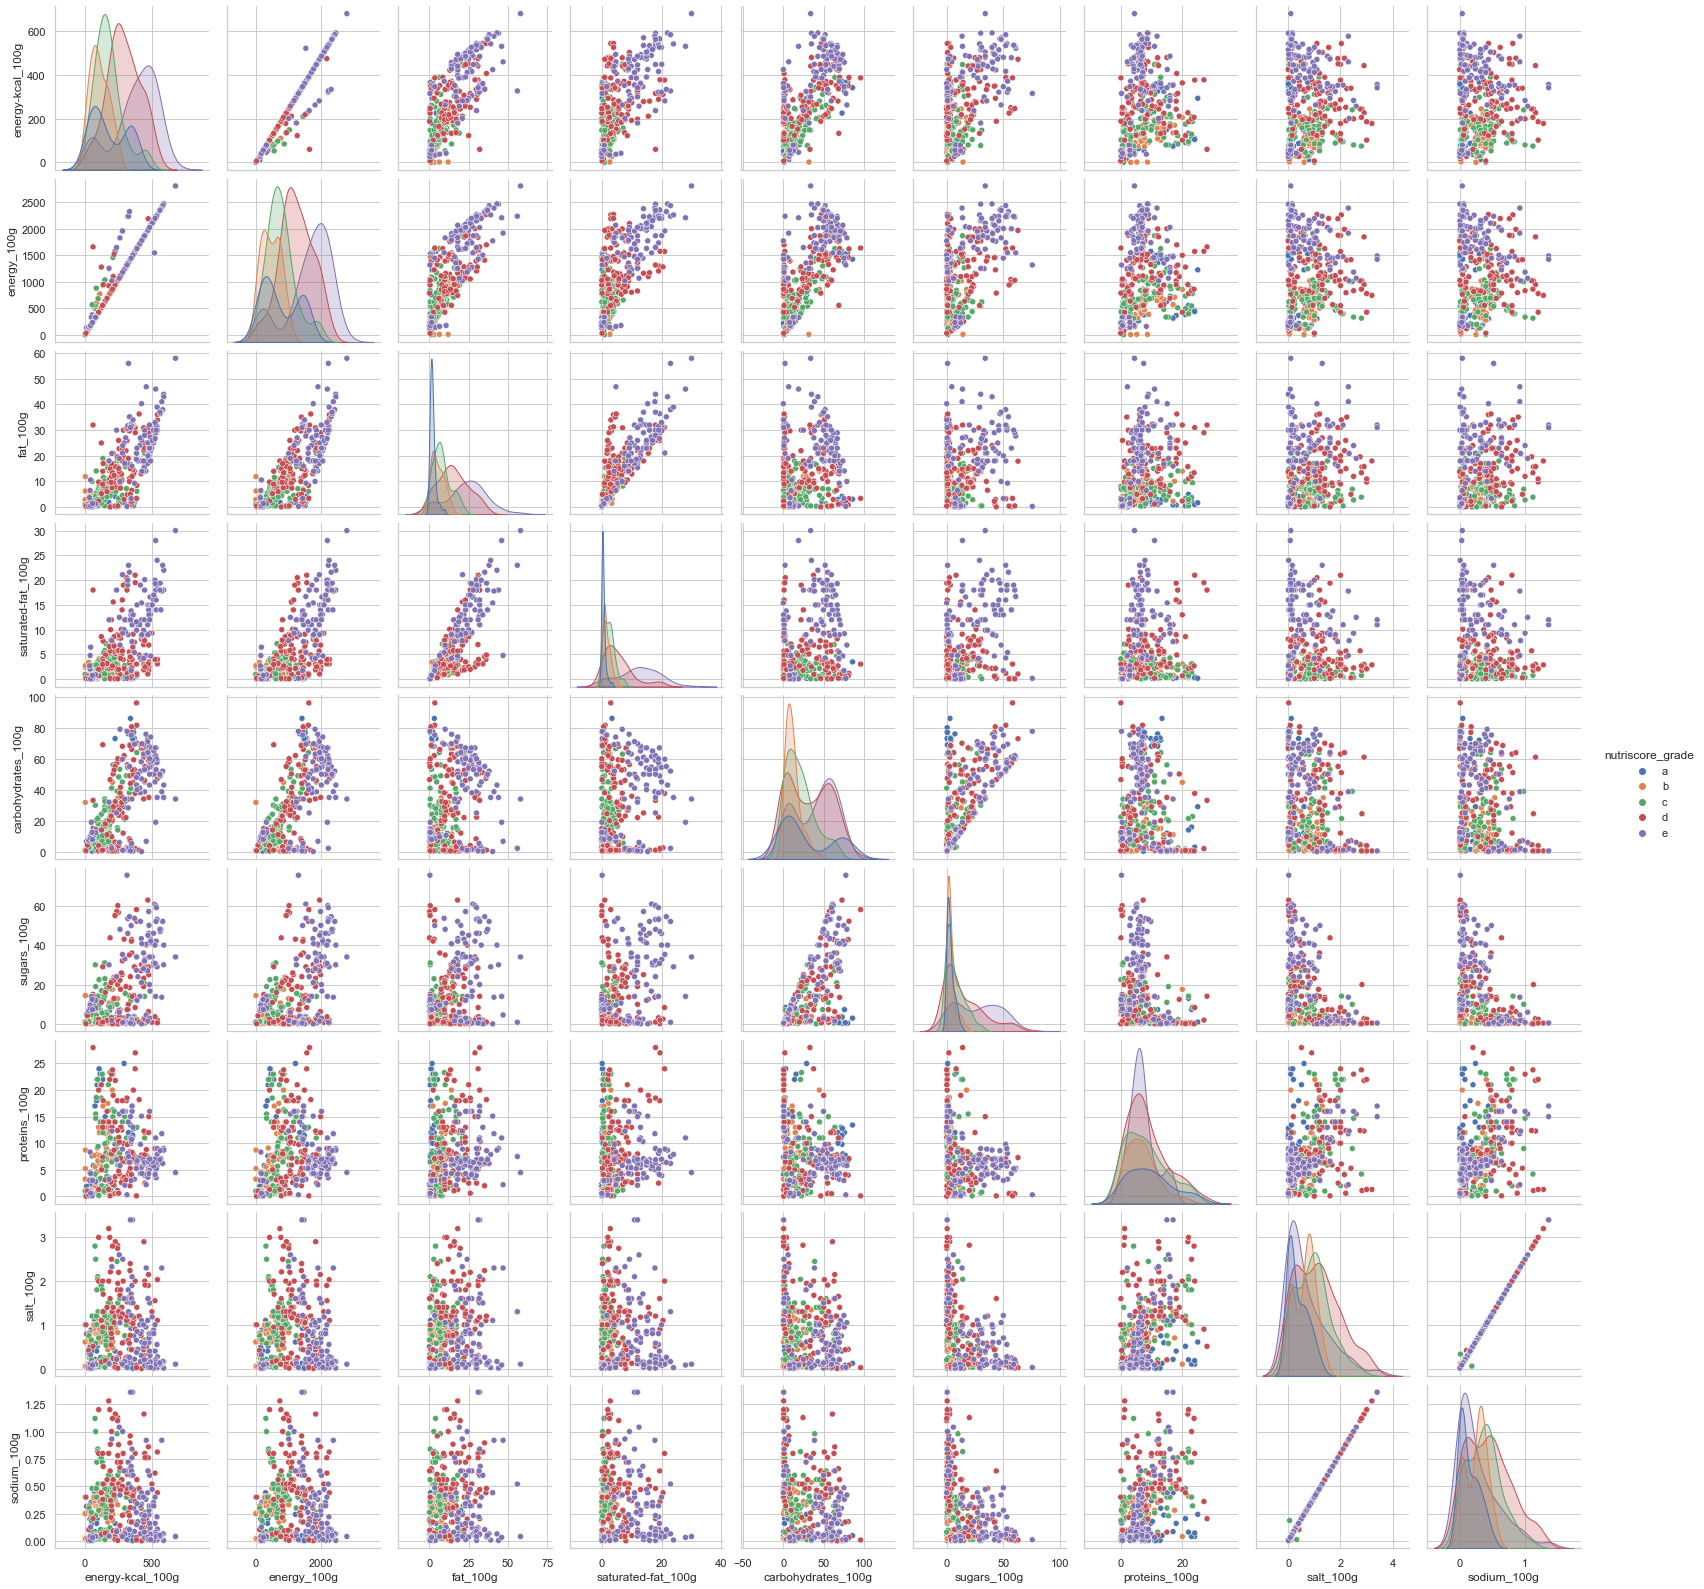

In [7]:
print("Nutriscore_grade relation pour chaque valeurs: ")
ax= sns.pairplot(data.sample(1000,random_state=0).sort_values(by="nutriscore_grade"),hue="nutriscore_grade")
plt.show()

En analysant les colonnes une à une il est difficile de se faire une idée sur nos hypothèses initiales. On remarque déjà la répartition du nombre de grade présent dans le jeu de données et la répartition des valeurs numériques de chaque colonne nutritionnelle associée aux autres colonnes ainsi que leur reparition par nutriscore_grade.<br><br>
Pour aller plus loin on va commencer par faire une **analyse descriptive du jeu de données grâce à l'ACP (Analyse en Composante Principale)** pour faire ressortir les informations clés du jeu de données.

## Analyse en Composante Principale (ACP)

In [8]:
# Partage équitable du jeu de données 
perfect_data = fair_distribution(data,"nutriscore_grade")

In [9]:
next_plan = widgets.Checkbox(value=True,description='Afficher uniquement n et n+1 plan',disabled=False,indent=False)
nb_composante=widgets.IntSlider(value=4, label='nb_composante',max=8,min=2,step=2)
max_value_display = widgets.IntText(value=20,description='Nombre d\'individu:',disabled=False)
col_display = widgets.SelectMultiple(
    options=quantitative,
    value=quantitative,
    description='Colonnes',
    disabled=False
)
@interact
def show_pca_dynamique(n_comp=nb_composante,
             next_plan=next_plan,
             nb_individu=max_value_display,
             col_disp=col_display):
    if len(list(col_disp)) < n_comp:
        print("Il est impossible de selectionner plus de composantes que de colonnes.")
    else:
        maxi = 500
        if nb_individu > maxi:
            nb_individu = maxi


        PCA_analysis(perfect_data[list(col_disp)],
                     all_plan(0,n_comp=n_comp,just_next_plan=next_plan),
                     n_comp=n_comp,
                     labels=np.array(list(col_disp)),
                     illustrative_var=perfect_data["nutriscore_grade"],
                     sample_individu=nb_individu,alpha=0.5)
        
        data_pca = perfect_data[list(col_disp)]
        X = data_pca.values
        names = data_pca.index
        features = data_pca.columns
        # Centrage et Réduction
        std_scale = preprocessing.StandardScaler().fit(X)
        X_scaled = std_scale.transform(X)

        # Calcul des composantes principales
        pca = decomposition.PCA(n_components=n_comp)
        pca.fit(X_scaled)
        X_projected = pca.fit_transform(X_scaled)
        g=pd.concat([pd.DataFrame(X_projected,index=names,columns=["F"+str(i+1) for i in range(n_comp)]),perfect_data],axis=1).groupby("nutriscore_grade")

        composante_data = pd.DataFrame(index=["F"+str(i+1) for i in range(n_comp)],columns=data_pca.columns,dtype="float64")
        for i in range(len(pca.components_)):
            for j in range(len(list(pca.components_[i]))):
                composante_data.loc["F"+str(i+1),data_pca.columns[j]]= float(pca.components_[i][j])
                
        disp(plot_heatmap(composante_data.T,"Composantes","Colonnes","Valeur de chaque composante pour chaque colonnes (vecteur)",fmt=".2f"))
        
        all_data = []
        for k in list(g.groups.keys()):
            all_data.append(pd.DataFrame(describe_data(g.get_group(k)[["F"+str(i+1) for i in range(n_comp)]],how=[np.number],numeric_value_return=True)[["mean"]]).rename(columns={"mean":k}))

        disp(plot_heatmap(pd.concat(all_data,axis=1),"Grades","Composantes","Moyenne des composante pour chaque nutriscore",fmt=".2f"))
        
        d=pd.concat([pd.DataFrame(X_projected,index=names,columns=["F"+str(i+1) for i in range(n_comp)]),perfect_data[list(col_disp)]],axis=1).corr()
        
        disp(plot_heatmap(d,"","","Corrélation des données avec les Composantes",fmt=".2f"))
 

interactive(children=(IntSlider(value=4, description='n_comp', max=8, min=2, step=2), Checkbox(value=True, des…

Grâce à l'ACP et **la composante F1**, on voit que la **corrélation avec le gras, gras saturé , sucre et glucide impact fortement l'énergie du produit** ("energy_100g" et "energy-kcal_100g"). On voit aussi que **cela entraine une augmentation du rang de nutriscore avec une augmentation croissante de la composante F1 du rang A à E**. On peut donc dire que le sucre et le gras influence le nutriscore et également l'énergie.<br>
On remarque **l'effet inverse pour la composante F4 qui est, elle, fortement corrélée avec la protéine**.<br><br>

Sur la **projection des individus des composante F3 et F4 on remarque un amas de point de rang A en haut a droite** ce qui correspond à **des produits qui contiennent beaucoup de protéine, de glucide et peu de graisse, graisse saturée** (car F3 correspond aux produits avec beaucoup de glucides mais peu de gras et F4 aux produits fortement proteinés mais peu de sucre et de sel) on peut donc penser que le rang A possède globalement plus de protéine et de glucide que les autres rangs et peu de graisse et de sucre.<br>
Sur la **projection d'individu des composantes F1 et F2 on remarque également que les produits de rang E se concentrent en haut et légèrement à gauche** ( en supprimant les colonnes "energy" ) ce qui indique des individus avec **beaucoup de sucre, glucide, gras et gras saturé et peu de protéine**.<br> <br>

On distinque aussi des **groupes de nutriments sur le plan F1 et F2** du cercle de corrélation ( si on enlève l'énergie ) : 

- Le **gras et gras saturé** que l'on classera dans les macro-nutriments **Lipides**
- Le **sucre et glucide** que l'on classera dans les macro-nutriments **Glucides**
- Les **protéines** seules que l'on classera dans les macro-nutriments **Protéines** 
- Le **sel et sodium** que l'on classera dans les macro-nutriments **Sel** 

Cette analyse en composante principal nous donne déjà beaucoup d'informations générales sur le jeu de données.
<br><br>
Pour rappel (recherche internet):
> L'energie n'est pas une valeur sur 100g elle quantifie **l'énergie du produit apporté à notre organisme** elle est mesurée en Joule et/ou en Kilo Calorie (il est possible de calculer son apport énergétique journalier).<br>
Pour les valeurs nutritionnelles on retrouve les macro-nutriments : **lipide** (nutriment : gras, gras saturé), **glucide**(nutriment : sucre rapide et lent),**protéine** et le **sel** quantifiés sur 100g.

Analysons la relation entre sel et sodium et l'énergie en Joule et KiloCalorie pour commencer puis la relation des grades pour chaque nutriment et macro nutriment.

## Comparative nutritionnel

In [10]:
diff_salt = data[["salt_100g","sodium_100g"]]
diff_salt["coefficient"] = (data["salt_100g"]/data["sodium_100g"]).round(2)
describe_data(diff_salt,how=[np.number])

,count,mean,std,min,25%,50%,75%,max
salt_100g,257648.000,0.775,0.716,0.000,0.146,0.616,1.200,4.050
sodium_100g,257648.000,0.310,0.287,0.000,0.060,0.248,0.480,1.620
coefficient,257648.000,2.581,1.892,0.000,2.500,2.500,2.500,200.670


In [11]:
percentage=(diff_salt[diff_salt["coefficient"]==2.5].shape[0] / diff_salt.shape[0])*100
print(f"Il y a {round(percentage,2)}% de valeurs égales à 2,5 pour le rapport entre le sel et le sodium.")

Il y a 95.18% de valeurs égales à 2,5 pour le rapport entre le sel et le sodium.


**Le sodium est un composant du sel (1g de sodium = 2.5g de sel).**
<br>
On retrouve quelques valeurs aberrantes qui peuvent être corrigées si nécessaire, cepandant on voit que plus de 75% des valeurs ont un coefficient parfaitement égale à 2,5.
<br><br>
Passons à l'analyse de l'énergie :

In [12]:
diff_energy = data[["energy_100g","energy-kcal_100g"]]
diff_energy["coefficient"] = (data["energy_100g"]/data["energy-kcal_100g"]).round(3)
describe_data(diff_energy,how=[np.number])

,count,mean,std,min,25%,50%,75%,max
energy_100g,257648.000,1014.345,688.764,0.420,410.000,941.000,1548.000,3556.000
energy-kcal_100g,257648.000,238.951,164.083,0.000,94.802,220.000,365.000,850.000
coefficient,257648.000,1504002.673,763410834.101,0.017,4.183,4.184,4.185,387500000000.000


In [13]:
percentage=(diff_energy[(diff_energy["coefficient"]>4.1) & (diff_energy["coefficient"]<4.3)].shape[0] / diff_energy.shape[0])*100
print(f"Il y a {round(percentage,2)}% de valeurs comprisent entre 4,1 et 4,3 pour le rapport entre l\'énergie en Joule et en KCalorie.")

Il y a 92.6% de valeurs comprisent entre 4,1 et 4,3 pour le rapport entre l'énergie en Joule et en KCalorie.


**Pour l'énergie le rapport est d'environ 4.2 entre l'énergie en Joule et en KiloCalories**
<br>
Même chose que pour le sel et sodium on voit des valeurs totalement aberrantes et la majorité des valeurs entre 4,1 et 4,3.
<br><br>
Maintenant analysons la répartition des valeurs nutritionnelles pour chaque grade afin de mieux comprendre à quoi correspondent les différents rangs de nutriscore.

[Text(0.5, 1.0, 'Répartition des valeurs nutritionnelles')]

[Text(0, 0.5, 'Valeur pour 100g')]

[Text(0.5, 0, 'Nutriment')]

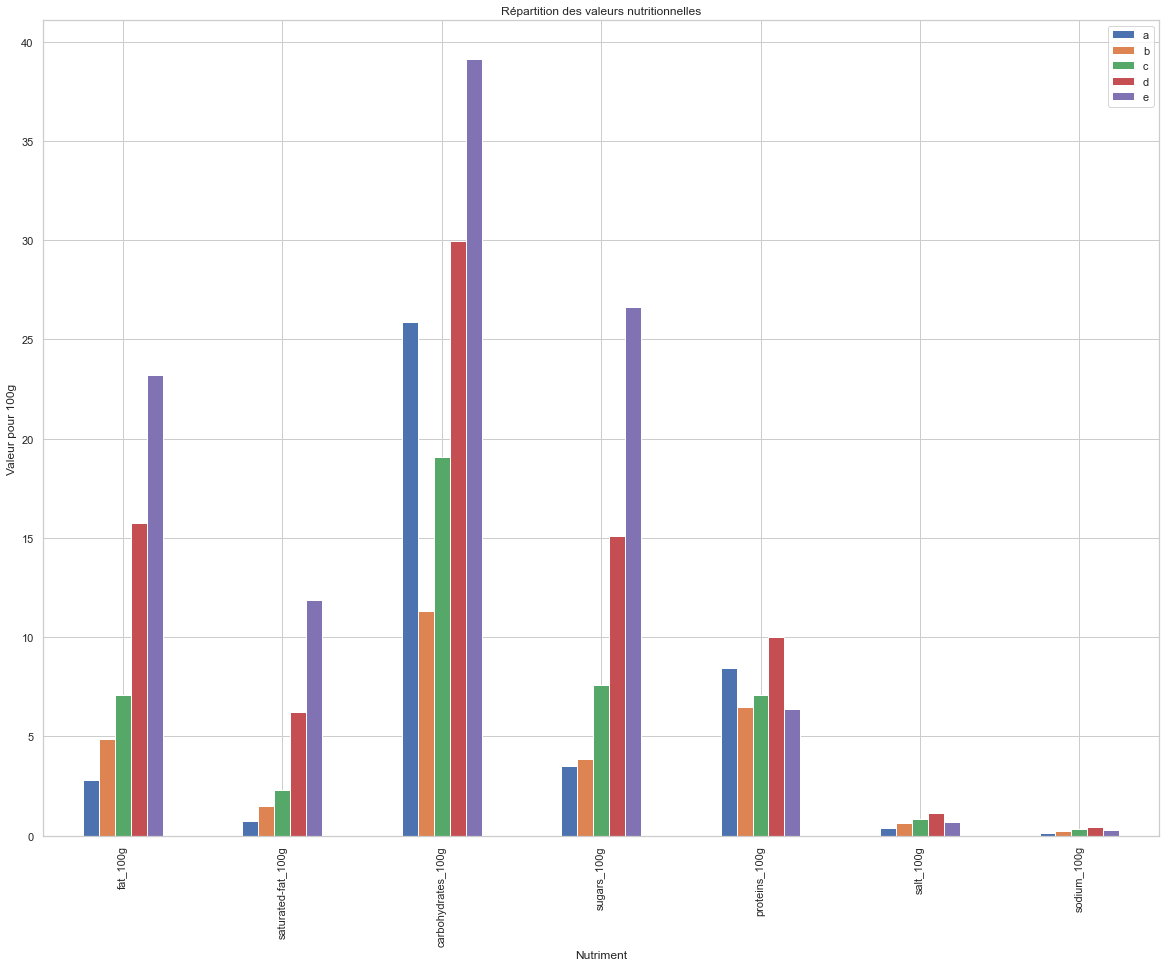

In [14]:
reparti = repartition_quantitative_values_rate(perfect_data,quantitative_exclude_energy,grouped_value="nutriscore_grade",normalize=False)
fig = reparti.plot.bar(figsize=(20,15),stacked=False)
fig.set(title="Répartition des valeurs nutritionnelles")
fig.set(ylabel="Valeur pour 100g")
fig.set(xlabel="Nutriment")
plt.show()

In [15]:
@interact
def show_anova(colonnes=quantitative):
    print(f"Analyse de la variance pour la colonne {colonnes} :")
    anova_analysis(perfect_data,"nutriscore_grade",colonnes,display_na=False,figsize=(15,10))

interactive(children=(Dropdown(description='colonnes', options=('energy-kcal_100g', 'energy_100g', 'fat_100g',…

Ces schémas de répartition permettent d'identifier les différences entre les nutriscores, on voit une **augmentation croissante des nutriments pour le gras, gras saturé et le sucre du rang A au rang E**.<br>
Sur l'ANOVA (ANlyse Of Variance), on voit que effectivement la variance est croissante pour le gras et gras saturé, même chose pour le sucre avec des médianes et Equart Interquartille qui évoluent également exponnetiellement du rang A à E.<br>
<br><br>
**Les autres nutriments ont une quantité sur 100g assez similaire** mais l'évolution de la répartition globale est différente (ex : si sur le rang A il y a moins de gras et gras saturé que le rang E mais autant de protéine alors le rang A a une proportion de protéine plus élevée même si la quantité sur 100g est équivalente).<br><br>

Malgré **la faible quantité de gras/gras saturé et sucre**, on remarque que le **nutriscore A**, sur l'analyse ANOVA reste **fortement énergétiques**, si on regarde sa répartition, le facteur qui indique cela ne peut être que le fort taux de glucide. On peut donc dire que **les glucides influence beaucoup l'énergie**.
<br><br>

Pour analyser cette différence on va analyser leur répartition global :

In [16]:
list_group = list(perfect_data.groupby("nutriscore_grade").groups.keys())
macro = widgets.Checkbox(value=False,description='Afficher par macronutriment',disabled=False,indent=False)
@interact
def show_repartition_nutriscore(nutriscore_grade=list_group,macro_nutriment=macro):
    group = perfect_data.groupby("nutriscore_grade")
    value = group[quantitative_exclude_energy].describe().loc[:,(slice(None),['mean'])]
    value.columns = value.columns.droplevel(level=1)
    value = value.T
    if macro_nutriment:
        t=value.drop(value.index)
        t.loc["lipide (gras / gras saturé)",] = value.loc["fat_100g"] + value.loc["saturated-fat_100g"]
        t.loc["glucide (sucre lent/rapide)"] = value.loc["sugars_100g"] + value.loc["carbohydrates_100g"]
        t.loc["protéine"] = value.loc["proteins_100g"]
        t.loc["sel"] = value.loc["salt_100g"]
        value=t
    all_value = value[nutriscore_grade]
    repartition = (1 - (all_value.sum() - all_value)/all_value.sum()) * 100
    repartition=pd.DataFrame(repartition).rename(columns={nutriscore_grade:"values"})
    repartition["labels"]=repartition.index
    repartition.iplot(kind="pie",labels="labels",values="values",sort=False)

interactive(children=(Dropdown(description='nutriscore_grade', options=('a', 'b', 'c', 'd', 'e'), value='a'), …

La répartition des nutriments indique une **évolution croissante du sucre, du gras et principalement du gras saturé et légèrement du sel pour aller du rang A à E**, et une **évolution décroissante pour la protéine du rang A à E**.<br>
En macro-nutriment on voit que **le rang B est le  mieux réparti** par rapport aux <a href="https://www.vidal.fr/sante/nutrition/equilibre-alimentaire-adulte/recommandations-nutritionnelles-adulte/en-pratique.html">valeurs de macro-nutriments conseillées</a>. <br><br>

**L'apport théorique jounralier est de:**
- **60% de glucide dont environ 1/3 de sucre**
- **15/25% de lipide dont environ 1/3 de graisses saturées**
- **15/25% de protéine (varie selon le poids et l'activité physique)**

On peut donc considérer **les produits de nutriscore A comme des produits faibles en sucre et lipide et fort en protéine**, ce qui semble plus adapté à des personnes ayant une forte activité physique ou voulant perdre du poids (prise de masse musculaire ou perte de graisse).<br><br>
>Les besoins nutritionnels peuvent donc varier selon les besoins et les activités de chaque personne. Pour maintenir une alimentation saine et équilibrée il est donc conseillé de prendre des aliments dont le nutriscore est au minimum C et de préférence de rang A (sportif avec un apport de sucre journalier supplémentaire nécessaire, comme des collations par exemple) ou bien de rang B.<br><br>


# Conclusion

Cette analyse permet de mieux comprendre les valeurs nutritionnelles et leurs associations au nutriscore Français.<br><br>
Les rang de nutriscore sont de bon indicateur de qualité nutritionnelle des aliments, on remarque également que le rang A est le plus bénéfique pour les régimes car il possèdent moins de lipide que les autres rang et provoquera donc une "carence" en graisse qui aura pour effet sur l'organisme de puisser les ressources de graisse nécessaire à l'organisme directement dans la réserve de graisse du corps. Après avoir un poids suffisant il est préférable de passer sur des nutriscore de rang B qui sont plus équilibrés.<br><br>
Il reste important de bien réguler le nombre de KCalorie conseillé pour éviter de stocker les nutriments qui n'ont pas été dépenser durant la journée.<br><br>

> Avec le jeu de données actuelle il est possible d'imputer les valeurs de nutriscore grade qui sont vide sur la base des valeurs nutritionnelle, il reste encore quelques valeurs aberrantes à éventuellement corriger ( notamment les valeurs identifiées sur l'énergie et le sel ) 



# Recherche de produit

In [17]:
def path_to_image_html(path):
    return '<img src="'+ path + '" style=max-height:124px;"/>'

def display_all_data_with_image(image_data,data):
    df = pd.concat([data,image_data],axis=1,join="inner")
    return HTML(df.to_html(escape=False ,formatters=dict(image_url=path_to_image_html)))

In [18]:
tab_key =  list(data.groupby("nutriscore_grade").groups.keys())
tab_key.append("nan")

list_value_group = widgets.Dropdown(options=[v for v in tab_key],value=tab_key[0],description='group:',disabled=False)
all_col = get_all_numeric_col(data)
max_value_display = widgets.IntSlider(value=10, label='Nombre de lignes',max=250,min=5,step=1)
all_group = widgets.Checkbox(value=True,description='Afficher tous les groupes',disabled=False,indent=False)

product = widgets.Text(
    value='',
    placeholder='Nom du produit',
    description='Produit :',
    disabled=False
)

# change display option
pd.options.display.max_rows = 250
pd.options.display.max_columns = 25

@interact
def show_product_sorted(group=list_value_group,
                        col_focus=all_col,
                        nb_row=max_value_display,
                        all_group=all_group,
                        produit=product):
    if all_group:
        if len(produit) < 2:
            disp_data = data.sort_values(col_focus,ascending=False).head(nb_row)
            disp(display_all_data_with_image(image,disp_data))
        else:
            find = data[data.index.str.contains(produit)]
            if find.shape[0]!=0:
                disp_data = find.sort_values(col_focus,ascending=False).head(nb_row)
                disp(display_all_data_with_image(image,disp_data))
            else:
                print("Aucun produit ne contient :",produit)
    else:
        if group!="nan":
            if len(produit) < 2:
                g = data.groupby("nutriscore_grade")
                value = g.get_group(group)
                disp_data = value.sort_values(col_focus,ascending=False).head(nb_row)
                disp(display_all_data_with_image(image,disp_data))
            else:
                g = data.groupby("nutriscore_grade")
                value = g.get_group(group)
                find = value[value.index.str.contains(produit)]
                if find.shape[0]!=0:
                    disp_data = find.sort_values(col_focus,ascending=False).head(nb_row)
                    disp(display_all_data_with_image(image,disp_data))
                else:
                    print("Aucun produit ne contient :",produit)
        else:
            if len(produit) < 2:
                value = data[data["nutriscore_grade"].astype(str)=="nan"]
                disp_data = value.sort_values(col_focus,ascending=False).head(nb_row)
                disp(display_all_data_with_image(image,disp_data))
            else:
                value = data[data["nutriscore_grade"].astype(str)=="nan"]
                find = value[value.index.str.contains(produit)]
                if find.shape[0]!=0:
                    disp_data = find.sort_values(col_focus,ascending=False).head(nb_row)
                    disp(display_all_data_with_image(image,disp_data))
                else:
                    print("Aucun produit ne contient :",produit)

interactive(children=(Dropdown(description='group:', options=('a', 'b', 'c', 'd', 'e', 'nan'), value='a'), Dro…